In [1]:
import os, gc
import pygrib
import numpy as np
import pandas as pd
import xarray as xr
import multiprocessing as mp
import matplotlib.pyplot as plt 

from glob import glob
from functools import partial
from matplotlib import gridspec
from datetime import datetime, timedelta

import regionmask
import cartopy
import cartopy.crs as ccrs
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

os.environ['OMP_NUM_THREADS'] = '1'
n_cores = 64

In [2]:
nbm_dir = '/scratch/general/lustre/u1070830/nbm/'

urma_dir = '/scratch/general/lustre/u1070830/urma/'
tmp_dir = '/scratch/general/lustre/u1070830/tmp/'
os.makedirs(tmp_dir, exist_ok=True)

In [3]:
start_date = datetime(2020, 10, 1, 0)
end_date = datetime(2021, 5, 15, 23, 59)

# start_date = datetime(2021, 3, 5, 0)
# end_date = datetime(2021, 3, 30, 0)

cwa = 'SLC'

In [4]:
urma = xr.open_dataset(urma_dir + 'agg/urma_agg.nc')
# urma = urma / 25.4
urma = urma['apcp24h_mm'].rename('apcp24h_in')
urma['lon'] = urma['lon'] - 360

# Screw with the timedelta... is there an issue with the labeling???
# urma['valid'] = urma['valid'] + np.timedelta64(0, 'h')

In [5]:
geodir = '../forecast-zones/'
zones_shapefile = glob(geodir + '*.shp')[0]

# Read the shapefile
zones = gpd.read_file(zones_shapefile)

# Prune to Western Region using TZ
zones = zones.set_index('TIME_ZONE').loc[['M', 'Mm', 'm', 'MP', 'P']].reset_index()
cwas = zones.dissolve(by='CWA').reset_index()[['CWA', 'geometry']]
_cwas = cwas.copy()

if cwa == 'WESTUS':
    _cwas['CWA'] = 'WESTUS'
    _cwas = _cwas.dissolve(by='CWA').reset_index()
    bounds = _cwas.total_bounds
else:
    bounds = _cwas[_cwas['CWA'] == cwa].bounds.values[0]
    
print(bounds)
    
lons, lats = urma.lon, urma.lat
mask = regionmask.mask_3D_geopandas(_cwas, lons, lats).rename({'region':'cwa'})
mask['cwa'] = _cwas.iloc[mask.cwa]['CWA'].values.astype(str)
mask = mask.sel(cwa=cwa)
mask

idx = np.where(
    (urma.lat >= bounds[1]) & (urma.lat <= bounds[3]) &
    (urma.lon >= bounds[0]) & (urma.lon <= bounds[2]))

mask = mask.isel(y=slice(idx[0].min(), idx[0].max()), x=slice(idx[1].min(), idx[1].max()))
urma = urma.isel(y=slice(idx[0].min(), idx[0].max()), x=slice(idx[1].min(), idx[1].max()))

[-114.05297852   36.9997139  -109.87454111   42.00161362]


In [6]:
#subset for only 0/12Z
urma = urma.sel(valid=np.array([t for t in urma.valid.values if pd.to_datetime(t).hour in [0, 12]]))
urma

<xarray.DataArray 'apcp24h_in' (valid: 393, y: 242, x: 172)>
[16358232 values with dtype=float32]
Coordinates:
    step     timedelta64[ns] ...
    lat      (y, x) float64 36.6 36.6 36.61 36.61 ... 42.34 42.35 42.35 42.35
    lon      (y, x) float64 -114.0 -113.9 -113.9 -113.9 ... -110.0 -110.0 -110.0
  * valid    (valid) datetime64[ns] 2020-11-02 ... 2021-05-17
Dimensions without coordinates: y, x

In [14]:
def extract_pqpf_verif_stats(_fhr, _urma, _mask):

#     nbm_file = glob(nbm_dir + 'extract/nbm_probx_fhr%03d.nc'%_fhr)[0]
#     nbm_file = glob(nbm_dir + 'f%03d_agg.nc'%_fhr)[0]
#     print(nbm_file)

    nbm_files = glob(nbm_dir + 'agg/*f%03d.WR.nc'%_fhr)
    print(nbm_files)
    
    # Subset the threshold value
    # nbm = xr.open_dataset(nbm_file)['probx'].isel(
    nbm = xr.open_mfdataset(nbm_files, concat_dim='valid')['probx'].isel(
        y=slice(idx[0].min(), idx[0].max()), 
        x=slice(idx[1].min(), idx[1].max()))
        
    # Subset the times
    nbm_time = nbm.valid
    urma_time = _urma.valid
    time_match = nbm_time[np.in1d(nbm_time, urma_time)].values
    time_match = np.array([t for t in time_match if pd.to_datetime(t) >= start_date])
    time_match = np.array([t for t in time_match if pd.to_datetime(t) <= end_date])
    
#     date0 = pd.to_datetime(time_match[0]).strftime('%Y/%m/%d %H UTC')
#     date1 = pd.to_datetime(time_match[-1]).strftime('%Y/%m/%d %H UTC')

    _nbm = nbm.sel(valid=time_match)
    _urma = _urma.sel(valid=time_match)
    nbm_mask, _nbm = xr.broadcast(_mask, _nbm)
    urma_mask, _urma = xr.broadcast(_mask, _urma)

    _nbm_masked = xr.where(nbm_mask, _nbm, np.nan)
    _urma_masked = xr.where(urma_mask, _urma, np.nan)
    
    return _nbm_masked, _urma_masked
    
_nbm_masked, _urma_masked = extract_pqpf_verif_stats(72, urma, mask)

['/scratch/general/lustre/u1070830/nbm/agg/blend.202101.qmd.f072.WR.nc', '/scratch/general/lustre/u1070830/nbm/agg/blend.202105.qmd.f072.WR.nc', '/scratch/general/lustre/u1070830/nbm/agg/blend.202010.qmd.f072.WR.nc', '/scratch/general/lustre/u1070830/nbm/agg/blend.202011.qmd.f072.WR.nc', '/scratch/general/lustre/u1070830/nbm/agg/blend.202102.qmd.f072.WR.nc', '/scratch/general/lustre/u1070830/nbm/agg/blend.202106.qmd.f072.WR.nc', '/scratch/general/lustre/u1070830/nbm/agg/blend.202103.qmd.f072.WR.nc', '/scratch/general/lustre/u1070830/nbm/agg/blend.202012.qmd.f072.WR.nc', '/scratch/general/lustre/u1070830/nbm/agg/blend.202104.qmd.f072.WR.nc']


In [15]:
_nbm_masked.valid

<xarray.DataArray 'valid' (valid: 384)>
array(['2020-11-02T00:00:00.000000000', '2020-11-02T12:00:00.000000000',
       '2020-11-03T00:00:00.000000000', ..., '2021-05-14T12:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-15T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    cwa       <U3 'SLC'
  * valid     (valid) datetime64[ns] 2020-11-02 ... 2021-05-15T12:00:00
    init      (valid) datetime64[ns] dask.array<chunksize=(4,), meta=np.ndarray>
    interval  int64 24
    step      timedelta64[ns] 1 days
    fhr       int64 72

In [8]:
stn_lat, stn_lon = 40.7899, -111.9791

# a = abs(_urma_masked.lat-stn_lat) + abs(_urma_masked.lon-stn_lon)
# i, j = np.unravel_index(a.argmin(), a.shape)

# _urma_masked = _urma_masked.isel(y=i, x=j)
# _nbm_masked = _nbm_masked.isel(y=i, x=j)

# _nbm_masked

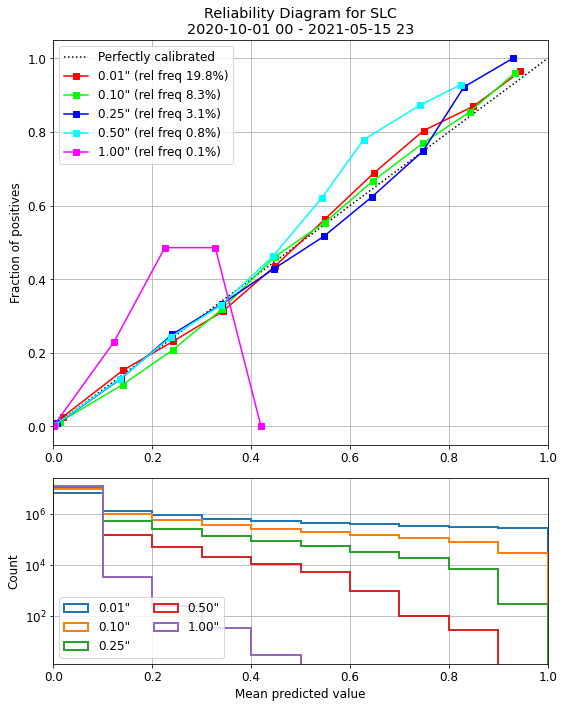

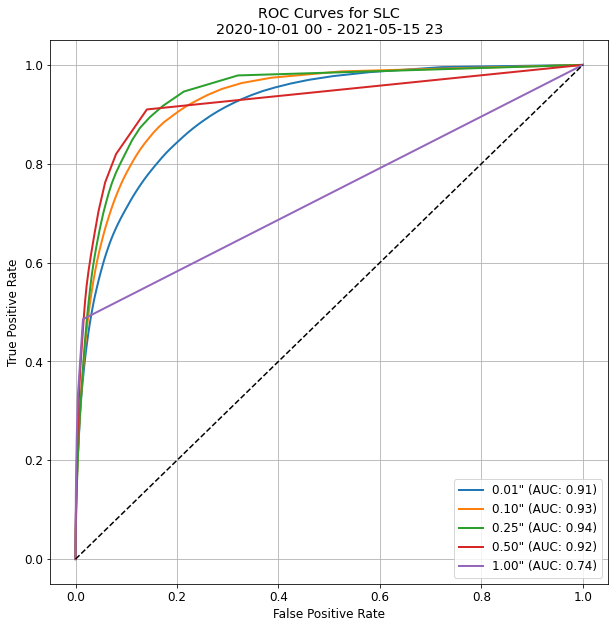

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.calibration import calibration_curve

wpc_thresholds = [0.254, 2.54, 6.35, 12.7, 25.4, 50.8, 76.2, 101.6]
wpc_thresholds_in = [0.01, 0.10, 0.25, 0.50, 1.0]
wpc_colors = ['red', 'lime', 'blue', 'cyan', 'magenta']
nbins = 10

plt.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(8, 10), facecolor='w')
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

fig1, ax = plt.subplots(1, figsize=(10, 10), facecolor='w')

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for threshold, threshold_in, color in zip(wpc_thresholds, wpc_thresholds_in, wpc_colors):
    
    _urma_flat = _urma_masked.values.flatten()
    _urma_flat_binary = np.where(_urma_flat >= threshold, True, False)

    try:
        _nbm_flat = _nbm_masked.sel(threshold=threshold).values.flatten()
        
    except:
        print('%.2f" Threshold Reliability Data Not Available'%threshold)
        
    else:
        nn = np.where(~np.isnan(_urma_flat) & ~np.isnan(_nbm_flat))


        fraction_of_positives, mean_predicted_value = \
            calibration_curve(_urma_flat_binary[nn], _nbm_flat[nn]/100, 
                              n_bins=nbins)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-", color=color,
                 label="%s" % ('%.2f" (rel freq %2.1f%%)'%(
                     threshold_in, 
                     100*(np.where(_urma_flat_binary[nn])[0].size/_urma_flat_binary[nn].size))))

        ax2.hist(_nbm_flat[nn]/100, range=(0, 1), bins=nbins, label='%.2f"'%threshold_in,
                 histtype='step', lw=2)
        
        try:
            fpr, tpr, roc_thresh = roc_curve(_urma_flat_binary[nn], _nbm_flat[nn]/100, 
                                             pos_label=True, drop_intermediate=True)
            
            auc = roc_auc_score(_urma_flat_binary[nn], _nbm_flat[nn]/100)

        except:
            print('%.2f" Threshold ROC Data Not Available'%threshold)
        
        else:
            ax.plot(fpr, tpr, linestyle='-', linewidth=2,
                    label='%.2f" (AUC: %.2f)'%(threshold_in, auc))

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

ax.grid()
ax.set_title('ROC Curves')
ax.legend(loc='lower right')

ax1.grid()
ax2.grid()
ax2.set_yscale('log')

ax1.set_ylabel('Fraction of positives')
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc='upper left')

ax.set_title('ROC Curves for %s\n%s - %s'%(
    cwa, start_date.strftime('%Y-%m-%d %H'), end_date.strftime('%Y-%m-%d %H')))

ax1.set_title('Reliability Diagram for %s\n%s - %s'%(
    cwa, start_date.strftime('%Y-%m-%d %H'), end_date.strftime('%Y-%m-%d %H')))

ax2.set_xlabel('Mean predicted value')
ax2.set_ylabel('Count')
ax2.legend(loc='lower left', ncol=2)

ax1.set_xlim([0, 1])
ax2.set_xlim([0, 1])

fig.tight_layout()

plt.show()

In [ ]:
threshold = 0.01*25.4

n_bins= 3
bins = np.linspace(0., 1. + 1e-8, n_bins + 1)

#4, 11
_urma_masked_coarse = _urma_masked.coarsen(dim={'x':4, 'y':11}).mean()
_nbm_masked_coarse = _nbm_masked.coarsen(dim={'x':4, 'y':11}).mean()

fraction_of_positives, mean_predicted_value = [], []

_urma_masked_binary = xr.where(_urma_masked_coarse > threshold, 
                               True, False)

for _urma_masked_flat, _nbm_masked_flat in zip(
    _urma_masked_binary.values.reshape(-1, _urma_masked.valid.size), 
    _nbm_masked_coarse.sel(threshold=threshold).values.reshape(-1, _urma_masked.valid.size)):
        
    fp, mp = calibration_curve(_urma_masked_flat, _nbm_masked_flat/100, n_bins=n_bins)
    
    if len(fp) != n_bins:
        fp = mp = np.full(n_bins, fill_value=np.nan, dtype=np.float)
        
    fraction_of_positives.append(fp)
    mean_predicted_value.append(mp)
    
fraction_of_positives = np.array(fraction_of_positives) 
mean_predicted_value = np.array(mean_predicted_value)

In [ ]:
spatial_frac_pos = xr.DataArray(
    fraction_of_positives.reshape(np.append(_urma_masked_binary.shape[:-1], n_bins))
).rename({'dim_0':'y', 'dim_1':'x', 'dim_2':'bin'})

spatial_frac_pos['lat'] = _urma_masked_binary.lat
spatial_frac_pos['lon'] = _urma_masked_binary.lon
spatial_frac_pos['bin'] = (bins[:-1] + bins[1:]) / 2

In [ ]:
bins_divided = np.linspace(0., 1. + 1e-8, n_bins*2 + 1)
bins_divided

In [ ]:
plt.rcParams.update({'font.size': 20})

fig, axs = plt.subplots(1, 3, figsize=(30, 12), 
    facecolor='w', subplot_kw=dict(projection=ccrs.PlateCarree()))

for plotbin, ax in enumerate(axs):
    
    zones.geometry.boundary.plot(color=None, linestyle='--', edgecolor='black', 
                                 linewidth=0.75, ax=ax)

    cwas.geometry.boundary.plot(color=None, edgecolor='black', linewidth=1.5, ax=ax)
    ax.add_feature(cartopy.feature.OCEAN, zorder=100, color='w', edgecolor=None)
    ax.add_feature(cartopy.feature.LAKES, zorder=100, color='gray', alpha=0.75, edgecolor='black', linewidth=2)

    ax.coastlines(linewidth=2, zorder=101)

    cbd = ax.contourf(spatial_frac_pos.lon, spatial_frac_pos.lat, spatial_frac_pos.isel(bin=plotbin),
                      levels=bins_divided)

    ax.set_title('bin: %.2f-%.2f'%(bins[plotbin], bins[plotbin+1]))
    
cbar_ax = fig.add_axes([0.18, 0, .65, .05]) #[1.01, .075, .05, .85])
cbar = plt.colorbar(cbd, orientation='horizontal', cax=cbar_ax)
cbar.ax.tick_params(labelsize=22)

plt.show()

In [ ]:
_nbm_masked